In [1]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

from omnifold_ori import omnifold as of
import os
import tensorflow as tf
import pandas as pd

2024-07-11 18:06:40.362887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[]


In [3]:
input_data = pd.read_csv("/Users/wingyanma/Documents/GitHub/pisa/pisa_examples/resources/events/J23_all_events.csv")


In [4]:
input_data

,Unnamed: 0,pdg,true_pid,reco_pid,reco_coszen_nue,reco_coszen_numu,reco_energy_nue,reco_energy_numu,true_coszen,true_energy,type,weight
0,0,14,numu,numu,0.494961,0.590685,0.853201,1.157009,0.855655,3.841143,1,1
1,1,14,numu,numu,0.274824,0.141403,4.300221,4.784906,0.113431,4.579452,1,1
2,2,14,numu,numu,0.242091,0.154218,2.578972,2.529813,0.404237,2.226287,1,1
3,3,14,numu,numu,-0.406088,-0.440340,2.419158,2.477218,-0.807746,2.606570,1,1
4,4,14,numu,numubar,0.597770,0.653224,3.485928,3.430741,0.187372,3.119193,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
94970,94970,14,nc,nc,0.357342,0.369064,1.798511,2.144140,0.681854,4.422088,0,1
94971,94971,-12,nc,nc,-0.290957,-0.492486,2.885988,3.517319,0.044246,5.999827,0,1
94972,94972,12,nc,nc,-0.570296,-0.735233,1.708040,1.500363,-0.395516,2.657809,0,1
94973,94973,14,nc,nc,-0.072436,-0.063474,4.060598,4.322109,-0.026144,7.631851,0,1


In [5]:
theta0m = input_data.sample(frac=0.7, random_state=1)
idx = theta0m.index
theta0u = input_data[~input_data.index.isin(idx)]
# theta0u = input_data[~input_data.isin(theta0m)]

In [6]:
len(theta0m), len(theta0u)

(66482, 28493)

In [7]:
theta0_G = theta0m['true_energy']
theta0_S = theta0m['reco_energy_nue']
theta0 = np.stack([theta0_S, theta0_G], axis=1)
theta_unknown_G = theta0u['true_energy']
theta_unknown_S = theta0u['reco_energy_nue']


In [8]:
N = 10**5

#Synthetic
theta0_G = np.random.normal(0.2,0.8,N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

# theta0 = np.stack([theta0_G, theta0_S], axis=1)
theta0 = np.stack([theta0_S, theta0_G], axis=1)

#Natural
theta_unknown_G = np.random.normal(0,1, N)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G]) 

In [8]:
len(np.concatenate((theta0_S, theta_unknown_S)))

94975

In [9]:
np.stack([theta0_S, theta0_S], axis=-1)

array([[4.2169166, 4.2169166],
       [0.7051771, 0.7051771],
       [0.8544829, 0.8544829],
       ...,
       [4.3290143, 4.3290143],
       [2.9140475, 2.9140475],
       [1.4386004, 1.4386004]])

In [10]:
# bins = np.linspace(-3,3,20)
bins = np.linspace(0,20,21)

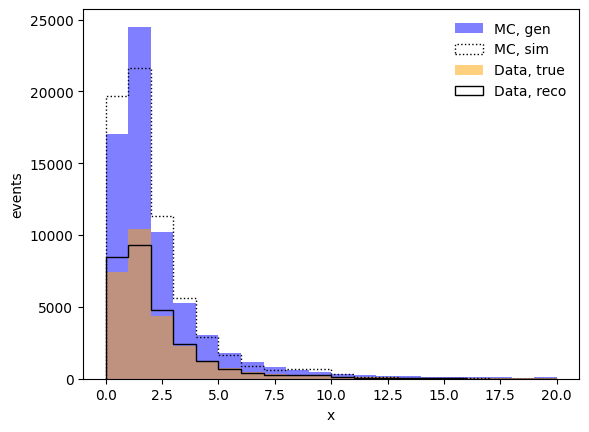

In [11]:
_,_,_=plt.hist(theta0_G,bins=bins,color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta0_S,bins=bins,histtype="step",color='black',ls=':',label="MC, sim")
_,_,_=plt.hist(theta_unknown_G,bins=bins,color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S,bins=bins,histtype="step",color='black',label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

In [12]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

2024-07-11 18:06:53.381805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
myweights = of(theta0,theta_unknown_G,2,model)

7/7 [==============================] - 0s 3ms/step


In [14]:
myweights.shape

(2, 2, 66482)

In [15]:
myweights

array([[[0.36686745, 0.43539524, 0.40655831, ..., 0.40196937,
         0.40322158, 0.40474018],
        [0.39627451, 0.42570469, 0.41875291, ..., 0.39579791,
         0.40185538, 0.40823629]],

       [[0.48882127, 0.43699145, 0.43858272, ..., 0.42321256,
         0.42470035, 0.42814353],
        [0.41285503, 0.44295052, 0.43881711, ..., 0.41270062,
         0.41465288, 0.42697766]]])

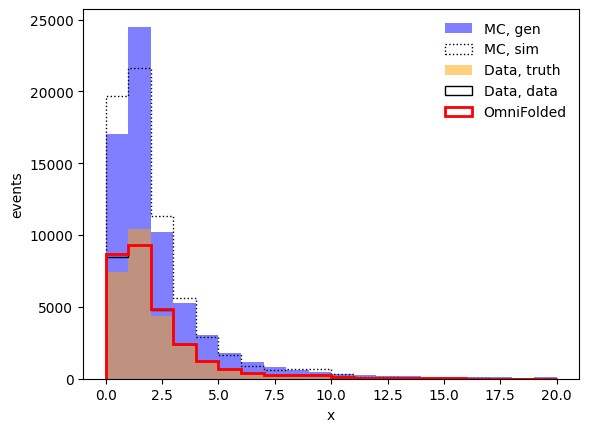

In [17]:
_,_,_=plt.hist(theta0_G,bins=bins,color='blue',alpha=0.5,label="MC, gen")
_,_,_=plt.hist(theta0_S,bins=bins,histtype="step",color='black',ls=':',label="MC, sim")
_,_,_=plt.hist(theta_unknown_G,bins=bins,color='orange',alpha=0.5,label="Data, truth")
_,_,_=plt.hist(theta_unknown_S,bins=bins,histtype="step",color='black',label="Data, data")
_,_,_=plt.hist(theta0_S,weights=myweights[-1, 0, :], bins=bins,color='red',histtype="step",label="OmniFolded",lw="2")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)